##### Copyright 2023 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# PaLM API: Tuning Quickstart with Python

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://developers.generativeai.google/tutorials/tuning_quickstart_python"><img src="https://developers.generativeai.google/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on Generative AI</a>
  </td>
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/tutorials/tuning_quickstart_python.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/tutorials/tuning_quickstart_python.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
    <td>
    <a target="_blank" href="https://developers.generativeai.google/tutorials/tuning_quickstart_python.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this notebook, you'll learn how to get started with the tuning service using the Python client library for the PaLM API. Here, you'll learn how to tune the text model behind the PaLM API's text generation service.

**Note**: At this time, the PaLM API is [only available in certain regions](https://developers.generativeai.google/available_regions).

## Setup

### Authenticate

The PaLM API lets you tune models on your own data. Since it's your data and
your tuned models this needs stricter access controls than API-Keys can provide.

Before you can run this tutorial, you'll need to
[setup OAuth for your project](oauth_quickstart.ipynb).

If you want to run this notebook in Colab start by uploading your
`client_secret*.json` file using the "File > Upload" option.

<img width=400 src="https://developers.generativeai.google/tutorials/images/colab_upload.png">

In [65]:
!cp service*.json service.json
!ls service.json

cp: 'service.json' and 'service.json' are the same file
service.json


This gcloud command turns the `client_secret.json` file into credentials that can be used to authenticate with the service.

Important: If you're running this in Colab, **don't just click the link it prints**. That will fail. Follow the instriuctions and copy the `gcloud` command it prints to your local machine and run it there, then paste the output from your local machine back here.

In [66]:
import os
if 'COLAB_RELEASE_TAG' in os.environ:
  # Use `--no-browser` in colab
  !gcloud auth application-default login --no-browser --client-id-file /content/service.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'
else:
  !gcloud auth application-default login --client-id-file /content/service.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'

You are authorizing client libraries without access to a web browser. Please run the following command on a machine with a web browser and copy its output back here. Make sure the installed gcloud version is 372.0.0 or newer.

gcloud auth application-default login --remote-bootstrap="https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=350971879985-t5v9v5ssveqejifu3fm8921stc2n08ca.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-language.tuning&state=bj23DNorKUDVwj6awWshlZkyZ7i9KN&access_type=offline&code_challenge=ifPfyylW_34TnU7IVR6o3kHE_8mPKjgQIL90HeN0mtA&code_challenge_method=S256&token_usage=remote"


Enter the output of the above command: https://localhost:8085/?state=bj23DNorKUDVwj6awWshlZkyZ7i9KN&code=4/0AfJohXm2sPJBr5RWn7ZwmPtUEtaZMYrXO2sdj8AsNBKGk0vAXKUsQksShDIhbU-hYg57Sg&scope=https://www.googleapis.com/auth/cloud-platform%20https://www.googleapis.com/auth/generati

### Install the client library

In [5]:
!pip install -q google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.9/267.9 kB 13.2 MB/s eta 0:00:00


### Import libraries

In [67]:
import google.generativeai as palm


You can check you existing tuned models with the `palm.list_tuned_model` method.

In [68]:
for i, m in zip(range(5), palm.list_tuned_models()):
  print(m.name)

tunedModels/teppertrainedllm-2csdufxp0ssa
tunedModels/tepper-6up2t4lcw5nb
tunedModels/generate-num-610


In [69]:
import base64
import json
import pprint

In [87]:
# These parameters for the model call can be set by URL parameters.
model = 'tunedModels/tepper-6up2t4lcw5nb' # @param {isTemplate: true}
temperature = 0.2 # @param {isTemplate: true}
candidate_count = 1 # @param {isTemplate: true}
top_k = 40 # @param {isTemplate: true}
top_p = 0.95 # @param {isTemplate: true}
max_output_tokens = 1024 # @param {isTemplate: true}
text_b64 = '' # @param {isTemplate: true}
stop_sequences_b64 = 'W10=' # @param {isTemplate: true}
safety_settings_b64 = 'W3siY2F0ZWdvcnkiOiJIQVJNX0NBVEVHT1JZX0RFUk9HQVRPUlkiLCJ0aHJlc2hvbGQiOjF9LHsiY2F0ZWdvcnkiOiJIQVJNX0NBVEVHT1JZX1RPWElDSVRZIiwidGhyZXNob2xkIjoxfSx7ImNhdGVnb3J5IjoiSEFSTV9DQVRFR09SWV9WSU9MRU5DRSIsInRocmVzaG9sZCI6Mn0seyJjYXRlZ29yeSI6IkhBUk1fQ0FURUdPUllfU0VYVUFMIiwidGhyZXNob2xkIjoyfSx7ImNhdGVnb3J5IjoiSEFSTV9DQVRFR09SWV9NRURJQ0FMIiwidGhyZXNob2xkIjoyfSx7ImNhdGVnb3J5IjoiSEFSTV9DQVRFR09SWV9EQU5HRVJPVVMiLCJ0aHJlc2hvbGQiOjJ9XQ==' # @param {isTemplate: true}

# Convert the prompt text param from a bae64 string to a string.
text = base64.b64decode(text_b64).decode("utf-8")

# Convert the stop_sequences and safety_settings params from base64 strings to lists.
stop_sequences = json.loads(base64.b64decode(stop_sequences_b64).decode("utf-8"))
safety_settings = json.loads(base64.b64decode(safety_settings_b64).decode("utf-8"))

defaults = {
  'model': model,
  'temperature': temperature,
  'candidate_count': candidate_count,
  'top_k': top_k,
  'top_p': top_p,
  'max_output_tokens': max_output_tokens,
  'stop_sequences': stop_sequences,
  'safety_settings': safety_settings,
}

# Show what will be sent with the API call.
pprint.pprint(defaults | {'prompt': text})

{'candidate_count': 1,
 'max_output_tokens': 1024,
 'model': 'tunedModels/tepper-6up2t4lcw5nb',
 'prompt': '',
 'safety_settings': [{'category': 'HARM_CATEGORY_DEROGATORY', 'threshold': 1},
                     {'category': 'HARM_CATEGORY_TOXICITY', 'threshold': 1},
                     {'category': 'HARM_CATEGORY_VIOLENCE', 'threshold': 2},
                     {'category': 'HARM_CATEGORY_SEXUAL', 'threshold': 2},
                     {'category': 'HARM_CATEGORY_MEDICAL', 'threshold': 2},
                     {'category': 'HARM_CATEGORY_DANGEROUS', 'threshold': 2}],
 'stop_sequences': [],
 'temperature': 0.2,
 'top_k': 40,
 'top_p': 0.95}


In [121]:
# Call the model and print the response.
response = palm.generate_text(
  **defaults,
  prompt="What is Tepper School of Business known for?"
)
print(response.candidates[0]['output'])

Tepper School of Business is known for its strong focus on ethics and social responsibility.


## Create tuned model

To create a tuned model, you need to pass your dataset to the model in the `palm.create_tuned_model` method. You can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

For this example, you will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

In [90]:
base_model = [
    m for m in palm.list_models()
    if "createTunedTextModel" in m.supported_generation_methods][0]
base_model.name

'models/text-bison-001'

In [92]:
import random

name = f'generate-num-{random.randint(0,10000)}'
operation = palm.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model="tunedModels/tepper-6up2t4lcw5nb",
    training_data=[{'text_input': "Who is teaching Business Communication for Analytical Decision Making?",
    'output': "Beth Walter"},
{
    'text_input': "Who is Beth Walter?",
    'output': "Beth Walter is Assistant Teaching Professor of Business Communication at Tepper School of Business, Carnegie Mellon University (CMU). She teaches undergraduate and graduate-level courses in business communication, presentation skills, professional writing, data communication, executive presence, and interpersonal managerial communication."
},
{
    'text_input': "What is the academic background of Beth Walter?",
    'output': "Duquesne University - Ph D (Communication and Rhetorical Studies) - 2014\nDuquesne University - MA (Philosophy) - 2004\nCarlow University - BA (English Literature and Philosophy) - 1996"
},
{
    'text_input': "What are Beth Walter's research interests?",
    'output': "Her most recent research focuses on pedagogical methods for making the contexts and conventions of business writing and their differences more explicit and accessible for business students. Beth also researches effective strategies for corporate communication about social responsibility initiatives."
},
{
    'text_input': "What is Beth Walter's email address?",
    'output': "bwalter@andrew.cmu.edu"
},
{
    'text_input': "Who is teaching Modern Data Management?",
    'output': "Bob Monroe"
},
{
    'text_input': "Who is Bob Monroe?",
    'output': "Dr. Robert T. Monroe is a Teaching Professor of Business Technologies in the Tepper School of Business at Carnegie Mellon University. Amongst other interests, his work explores ways that companies use AI and Machine Learning to do business better, faster, and cheaper."
},
{
    'text_input': "What is the academic background of Bob Monroe?",
    'output': "Carnegie Mellon University - Ph D (Computer Science) - 1999\nCarnegie Mellon University - MS (Computer Science) - 1995\nUniversity of Michigan - BS (Computer Science and Philosophy) - 1993"
},
{
    'text_input': "What are Bob Monroe's research interests?",
    'output': "His research interests span a broad array of topics and disciplines. He finds that many of the most interesting research questions are found in the gaps between well-established research areas."
},
{
    'text_input': "What is Bob Monroe's email address?",
    'output': "rm74@andrew.cmu.edu"
},
{
    'text_input': "Who is teaching Optimization for Prescriptive Analytics?",
    'output': "Andrew A Li"
},
{
    'text_input': "Who is Andrew A Li?",
    'output': "He is the Assistant Professor of Operations Research at CMU Tepper. His research interests are in statistics, optimization, and machine learning, with applications to operations management and medicine. He is currently funded by an NSF Career Award."
},
{
    'text_input': "What is the academic background of Andrew A Li?",
    'output': "Massachusetts Institute of Technology - Ph D (Operations Research) - 2018\nColumbia University - BS (Operations Research/Applied Mathematics Minor) - 2012"
},
{
    'text_input': "What are Andrew Li's research interests?",
    'output': "Li’s research interests include statistics, optimization and machine learning, with applications to operations management and medicine."
},
{
    'text_input': "What is Andrew Li's email address?",
    'output': "aali1@cmu.edu"
},
{
    'text_input': "Who is teaching Statistical Foundations of Business Analytics?",
    'output': "Mattia Ciollaro"
},
{
    'text_input': "Who is Mattia Ciollaro?",
    'output': "Mattia is a Teaching Professor at Carnegie Mellon University. Prior to Carnegie Mellon University, he was a Consulting Professor at Duke University. Every year, Mattia helps hundreds of students learn how to solve real-world problems using Data Science and Machine Learning. Mattia also worked as a technical leader at Amazon Alexa and PayPal, where he contributed to the design and implementation of both experimental and production-grade Machine Learning and Artificial Intelligence systems."
},
{
    'text_input': "What is the academic background of Mattia Ciollaro?",
    'output': "Carnegie Mellon University - Ph D (Statistics) - 2016\nCarnegie Mellon University - MS (Statistics) - 2013\nCollegio Carlo Alberto - MA (Statistics and Applied Mathematics (with distinction) - 2012\nUniversità degli Studi di Torino - MA (Statistics (with distinction) - 2012\nCollegio Carlo Alberto - Allievo Junior Diploma (Statistics and Applied Mathematics) - 2010\nUniversità degli Studi di Torino - BA (Statistics) - 2010"
},

{
    'text_input': "Who is the associate dean of master programs?",
    'output': "Kate Barraclough"
},
{
    'text_input': "Who is Kate Barraclough?",
    'output': "She has 10+ years of progressive experience as an educator and a leader of educational programs. She currently oversees Carnegie Mellon’s MBA programs (full-time, part-time and online). She teaches graduate business classes in Derivative Securities, Debt Markets, Financial Modeling, and Introductory Finance (online)."
},
{
    'text_input': "What is the academic background of Kate Barraclough?",
    'output': "Australian National University - Ph D (Finance) - 2007\nAustralian National University - BA (Commerce) - 2000\nAustralian National University - BA (Economics) - 2000"
},
{
    'text_input': "What is Kate Barraclough's email address?",
    'output': "kbarracl@andrew.cmu.edu"
},
{
    'text_input': "Who is the assistant Dean, Tepper Masters Programs?",
    'output': "C. Tad Brinkerhoff"
},
{
    'text_input': "Who is C. Tad Brinkerhoff?",
    'output': "He is the Assistant Dean of Masters Programs at the Tepper School of Business at Carnegie Mellon University in Pittsburgh, Pennsylvania. Previous experience includes 20+ years of extensive leadership and administrative experience in MBA program management, education technology, executive education, international initiatives and programs, international and domestic student recruiting, corporate development, career development, and student services."
},
{
    'text_input': "What is the academic background of C. Tad Brinkerhoff?",
    'output': "Southern Utah University - BA (Languages, Chemistry) - 1989; Brigham Young University - MBA (strategy, International Business) - 1993; Brigham Young University- Ph D (higher Education Administration) - 2012"
},
{
    'text_input': "What is C. Tad Brinkerhoff's email address?",
    'output': "tbrinker@andrew.cmu.edu"
}],
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
)

Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [93]:
model = palm.get_tuned_model(f'tunedModels/tepper-6up2t4lcw5nb')

model

TunedModel(name='tunedModels/tepper-6up2t4lcw5nb',
           source_model='models/text-bison-001',
           base_model='models/text-bison-001',
           display_name='tepper',
           description=('{"description":"","exampleInput":"input: Who is teaching Business '
                        'Communication for Analytical Decision Making","exampleOutput":"output: Beth '
                        'Walter","datasourceUrl":"prompts/1rLXd3AXCBub6ix1SJ8ykLHXAcWjSXuB5","showedTuningComplete":false,"rowsCount":115}'),
           temperature=0.7,
           top_p=0.95,
           top_k=40,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2023, 11, 2, 22, 19, 47, 256359, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2023, 11, 2, 22, 23, 1, 489134, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2023, 11, 2, 22, 19, 48, 55695, tzinfo=datetime.timezone.utc),
                                  comp

In [94]:
model.state

<State.ACTIVE: 2>

### Check tuning progress

Use `metadata` to check the state:

In [95]:
operation.metadata

total_steps: 675
tuned_model: "tunedModels/generate-num-8962"

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [96]:
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/675 [00:00<?, ?it/s]

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [ ]:
# operation.cancel()

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://generativeai.devsite.corp.google.com/guide/model_tuning_guidance#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

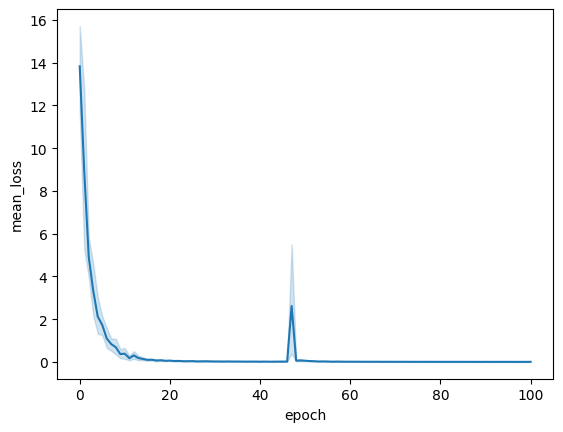

In [97]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')


## Evaluate your model

You can use the `palm.generate_text` method and specify the name of your model to test your model performance.

In [102]:
completion = palm.generate_text(model=f'tunedModels/tepper-6up2t4lcw5nb',
                                prompt='Who is the instructor for Data Analytics in Finance?')
completion.result

'Answer: The instructor for Data Analytics in Finance is Zeigham Khokher.'

In [111]:
completion = palm.generate_text(model=f'tunedModels/tepper-6up2t4lcw5nb',
                                prompt='What time does the Ethics & AI lecture take place?')
completion.result

'Answer: The lecture for Ethics & AI is from 4 PM to 5:45 PM.'

In [112]:
completion = palm.generate_text(model=f'tunedModels/tepper-6up2t4lcw5nb',
                                prompt='Who is the instructor for Ethics & AI?')
completion.result

'The instructor for Ethics & AI is Derek Leben.'

## Update the description

You can update the description of your tuned model any time using the `palm.update_tuned_model` method.

In [113]:
palm.update_tuned_model(f'tunedModels/tepper-6up2t4lcw5nb', {"description":"This is the model tuned for Tepper School"})

TunedModel(name='',
           source_model=None,
           base_model=None,
           display_name='',
           description='This is the model tuned for Tepper School',
           temperature=None,
           top_p=None,
           top_k=None,
           state=<State.STATE_UNSPECIFIED: 0>,
           create_time=None,
           update_time=None,
           tuning_task=None)

In [114]:
model = palm.get_tuned_model(f'tunedModels/tepper-6up2t4lcw5nb')

model

TunedModel(name='tunedModels/tepper-6up2t4lcw5nb',
           source_model='models/text-bison-001',
           base_model='models/text-bison-001',
           display_name='tepper',
           description='This is the model tuned for Tepper School',
           temperature=0.7,
           top_p=0.95,
           top_k=40,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2023, 11, 2, 22, 19, 47, 256359, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2023, 11, 2, 22, 23, 1, 489134, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2023, 11, 2, 22, 19, 48, 55695, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2023, 11, 2, 22, 23, 1, 489134, tzinfo=datetime.timezone.utc),
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=10,
                                              

In [115]:
model.description

'This is the model tuned for Tepper School'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `palm.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [ ]:
#palm.delete_tuned_model(f'tunedModels/{name}')

#try:
#  m = palm.get_tuned_model(f'tunedModels/{name}')
#  print(m)
#except Exception as e:
#  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 Tuned model tunedModels/generate-num-4668 does not exist.
